# 职位信息可视化推荐系统 - 数据分析报告

## 项目概述

本项目基于 Django 框架开发的智能职位推荐系统，集成了数据采集、清洗、分析、建模和可视化的完整数据工程流程。

**核心功能：**
- 🕷️ 自动化数据采集（Selenium 爬虫）
- 🧹 智能数据清洗与去重
- 🤖 混合推荐算法（协同过滤 + 意向匹配）
- 📊 K-Means 职位聚类分析
- 📈 多维度数据可视化

**技术栈：**
- 后端：Django 3.2.8 + MySQL
- 爬虫：Selenium + multiprocessing
- 分析：pandas + numpy + scikit-learn
- 可视化：matplotlib + seaborn

---


In [ ]:
%%sql


## 1.1 环境配置与系统集成

配置 Django 环境，连接数据库，导入必要的库。


In [1]:
import os
import django
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# 设置 Django 环境
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "JobRecommend.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

# 导入模型
from job import models

print("✅ Django 环境配置成功，模型已加载。")

✅ Django 环境配置成功，模型已加载。


In [2]:
# 🛡️ 数据库连接卫士：解决远程连接超时问题
from django.db import connection, close_old_connections
import django

def refresh_db_connection():
    """手动刷新数据库连接，防止 (2013, 'Lost connection') 错误"""
    try:
        # 关闭所有过时或失效的连接
        close_old_connections()
        # 强制建立新连接
        connection.ensure_connection()
        print("✅ 数据库连接已刷新，可安全进行查询。")
    except Exception as e:
        print(f"⚠️ 数据库刷新失败: {e}")

# 立即执行一次刷新
refresh_db_connection()

✅ 数据库连接已刷新，可安全进行查询。


# 第二章 数据采集：智能爬虫系统

## 章节概述

本章展示基于 Selenium 的分布式自动化爬虫系统，包括反爬虫策略、多线程并发采集和实时数据展示。

---

## 2.1 爬虫核心架构

爬虫系统采用线程池技术，支持多页面并发采集，并配置了完善的反爬虫机制。


In [3]:
# 展示爬虫函数签名和关键逻辑
from job import tools
import inspect

print("📝 爬虫函数签名：")
print("=" * 80)
sig = inspect.signature(tools.lieSpider)
print(f"lieSpider{sig}")

print("\n🔑 关键参数说明：")
print("  - key_word: 搜索关键词（如 'Python'）")
print("  - city: 目标城市（如 '北京'）")
print("  - all_page: 爬取页数（每页约15条职位）")

print("\n💡 核心机制：")
print("  1. 构建搜索 URL")
print("  2. 使用 Selenium 访问页面")
print("  3. 提取职位数据（XPath）")
print("  4. update_or_create 自动去重")
print("  5. 多线程并发处理")

📝 爬虫函数签名：
lieSpider(key_word, city, all_page)

🔑 关键参数说明：
  - key_word: 搜索关键词（如 'Python'）
  - city: 目标城市（如 '北京'）
  - all_page: 爬取页数（每页约15条职位）

💡 核心机制：
  1. 构建搜索 URL
  2. 使用 Selenium 访问页面
  3. 提取职位数据（XPath）
  4. update_or_create 自动去重
  5. 多线程并发处理


## 2.2 实时爬取演示

执行真实的爬虫任务，采集职位数据并**自动保存到数据库和CSV文件**。

**重要说明：**
- 爬虫会自动执行数据清洗和去重
- 数据同时保存到数据库（MySQL）和CSV文件（`data/` 目录）
- CSV文件供后续所有分析使用


In [4]:
from job.tools import lieSpider
import time

print("🕷️ 启动真实爬虫...")
print("=" * 80)
print("配置：")
print("  关键词: Python")
print("  城市: 北京")
print("  页数: 1")
print("\n⏳ 执行中，预计需要 30-60 秒...\n")

start_time = time.time()

try:
    # 调用项目中的真实爬虫函数
    result = lieSpider(
        key_word='Python',
        city='北京',
        all_page='1'
    )

    elapsed = time.time() - start_time

    print("\n" + "=" * 80)
    print("✅ 爬虫执行完成！")
    print(f"⏱️  耗时: {elapsed:.2f} 秒")
    print(f"📊 返回状态: {result}")
    print("\n💾 数据已写入数据库")

except Exception as e:
    print(f"\n❌ 执行出错: {str(e)}")
    print("请检查：")
    print("  1. ChromeDriver 是否正确安装")
    print("  2. 网络连接是否正常")
    print("  3. 数据库连接是否可用")

🕷️ 启动真实爬虫...
配置：
  关键词: Python
  城市: 北京
  页数: 1

⏳ 执行中，预计需要 30-60 秒...

[10:37:12] [INFO] ========== 爬虫任务启动 ==========
[10:37:12] [INFO] 搜索关键词: Python
[10:37:12] [INFO] 目标城市: 北京
[10:37:12] [INFO] 爬取页数: 1
[10:37:12] [INFO] 生成待爬取链接数: 1
[10:37:12] [INFO]   链接1: https://www.liepin.com/zhaopin/?city=010&dqs=010&key=Python&currentPage=1
[10:37:12] [INFO] 开始多线程爬取，线程池大小: 3
[10:37:12] [INFO] [页面1] 开始爬取...
[10:37:18] [INFO] [页面1] 职位列表已加载
[10:37:38] [INFO] [页面1] 解析数据: 职位=40, 薪资=40, 公司=40
[10:37:38] [SUCCESS] [页面1] 成功获取 40 条职位数据
[10:38:08] [SUCCESS] [页面1] 新增 26 条，14 条重复已更新
[10:38:16] [INFO] 成功导出 40 条数据到 job_data_Python_北京_20260109_103815.csv
[10:38:17] [SUCCESS] 数据已导出到CSV: D:\Python\Python_Path\src\JobRecommend_server\data\job_data_Python_北京_20260109_103815.csv
[10:38:17] [SUCCESS] ========== 爬虫任务完成 ==========

✅ 爬虫执行完成！
⏱️  耗时: 64.42 秒
📊 返回状态: 0

💾 数据已写入数据库


## 2.3 采集数据展示

查看爬取到的原始数据样本。


In [5]:
refresh_db_connection()

print("📋 最新爬取的数据（Top 10）：")
print("=" * 80)

# 查询最新的10条数据
recent_jobs = models.JobData.objects.all().order_by('-job_id')[:10]

for idx, job in enumerate(recent_jobs, 1):
    print(f"\n【{idx}】{job.name}")
    print(f"  🏢 公司: {job.company}")
    print(f"  💰 薪资: {job.salary}")
    print(f"  📍 地点: {job.place}")
    print(f"  🎓 学历: {job.education}")
    print(f"  ⏱️  经验: {job.experience}")
    print(f"  🔑 关键词: {job.key_word}")

print(f"\n✅ 共展示 {len(recent_jobs)} 条最新数据")

✅ 数据库连接已刷新，可安全进行查询。
📋 最新爬取的数据（Top 10）：

【1】后端开发工程师(Golang/Python）
  🏢 公司: 
  💰 薪资: 25-45k·16薪
  📍 地点: 北京-海淀区
  🎓 学历: 本科
  ⏱️  经验: 1-3年
  🔑 关键词: Python

【2】Python开发
  🏢 公司: 
  💰 薪资: 25-40k·15薪
  📍 地点: 北京-朝阳区
  🎓 学历: 统招本科
  ⏱️  经验: 3-5年
  🔑 关键词: Python

【3】Python开发工程师
  🏢 公司: 瑞鑫天算
  💰 薪资: 15-30k
  📍 地点: 北京-海淀区
  🎓 学历: 统招本科
  ⏱️  经验: 经验不限
  🔑 关键词: Python

【4】Python后端开发工程师
  🏢 公司: 
  💰 薪资: 24-45k
  📍 地点: 北京
  🎓 学历: 学历不限
  ⏱️  经验: 3-5年
  🔑 关键词: Python

【5】Python后端开发工程师
  🏢 公司: 某知名互联网公司
  💰 薪资: 30-60k·16薪
  📍 地点: 北京-海淀区
  🎓 学历: 本科
  ⏱️  经验: 3-5年
  🔑 关键词: Python

【6】Software Developer（Java或Python后端开发）北京-Amazon
  🏢 公司: 某上海大型专业技术服务公司
  💰 薪资: 20-30k
  📍 地点: 北京
  🎓 学历: 本科
  ⏱️  经验: 3-5年
  🔑 关键词: Python

【7】【头部量化基金】测试开发工程师，（需精通 Python 开发）
  🏢 公司: 某北京基金/证券/期货公司
  💰 薪资: 30-50k·16薪
  📍 地点: 北京
  🎓 学历: 统招本科
  ⏱️  经验: 5年以上
  🔑 关键词: Python

【8】Python后端开发工程师
  🏢 公司: 
  💰 薪资: 20-30k·15薪
  📍 地点: 北京-海淀区
  🎓 学历: 统招本科
  ⏱️  经验: 5-10年
  🔑 关键词: Python

【9】Python数据开发工程师
  🏢 公司: 某北京基金/证券/期货公司
  💰 薪资: 30-50k·16薪
  

## 2.4 数据采集统计

统计本次爬取的数据量和质量。


In [6]:
refresh_db_connection()

print("📊 爬虫系统运行统计：")
print("=" * 80)

# 获取爬虫统计信息
spider_info = models.SpiderInfo.objects.filter(spider_id=1).first()

if spider_info:
    print(f"\n  爬虫名称: {spider_info.spider_name}")
    print(f"  运行次数: {spider_info.count} 次")
    print(f"  累计爬取页数: {spider_info.page} 页")
    print(f"  预估采集职位: ~{spider_info.page * 25} 条")

# 数据库实际记录数
total_jobs = models.JobData.objects.count()
print(f"\n  数据库实际职位数: {total_jobs} 条")

# 按关键词统计
from django.db.models import Count
keyword_stats = models.JobData.objects.values('key_word').annotate(
    count=Count('job_id')
).order_by('-count')[:5]

print(f"\n  Top 5 热门关键词：")
for idx, stat in enumerate(keyword_stats, 1):
    keyword = stat['key_word'] or '(未分类)'
    print(f"    {idx}. {keyword}: {stat['count']} 条")

# 按城市统计
city_stats = models.JobData.objects.values('place').annotate(
    count=Count('job_id')
).order_by('-count')[:5]

print(f"\n  Top 5 热门城市：")
for idx, stat in enumerate(city_stats, 1):
    city = stat['place'][:10] if stat['place'] else '(未知)'
    print(f"    {idx}. {city}: {stat['count']} 条")

✅ 数据库连接已刷新，可安全进行查询。
📊 爬虫系统运行统计：

  爬虫名称: spider
  运行次数: 86 次
  累计爬取页数: 357 页
  预估采集职位: ~8925 条

  数据库实际职位数: 11053 条

  Top 5 热门关键词：
    1. java: 1237 条
    2. web: 1153 条
    3. 测试: 1127 条
    4. python: 1074 条
    5. 前端: 1059 条

  Top 5 热门城市：
    1. 重庆-渝北区: 531 条
    2. 大连-甘井子区: 429 条
    3. 重庆: 374 条
    4. 苏州-工业园区: 362 条
    5. 深圳-南山区: 297 条


## 数据使用流程

### 步骤1：运行爬虫生成数据
```python
from job.tools import lieSpider
lieSpider('Python', '北京', '2')  # 关键词、城市、页数
```

### 步骤2：数据自动保存
- **数据库**：MySQL (job_jobdata 表)
- **CSV文件**：`data/job_data_Python_北京_20251221_*.csv`

### 步骤3：后续分析使用CSV
所有后续分析（特征工程、聚类、可视化）都使用同一个CSV文件，确保数据一致性。

---


# 第三章 数据处理：清洗与去重

## 章节概述

本章介绍数据清洗流程，包括CSV数据与数据库数据的对比、重复数据检测和处理流程演示。

---


## 3.1 重复数据验证

对比CSV文件中的数据与数据库中的现有数据，识别重复记录。

**验证逻辑：**
- 联合唯一键：(职位名称, 公司名称, 工作地点)
- 如果三个字段完全匹配，则视为重复数据


In [7]:
# 3.1 重复数据验证 (智能版)
# 目标：抽取CSV中的样本，并在数据库中精确查找，以验证重复情况。

import pandas as pd
import glob
import os
import django
from job import models
from IPython.display import display

print("--- 正在加载并验证数据源 ---")

# --- 步骤 1: 加载最新的CSV文件 ---
data_dir = 'data/'
csv_files = glob.glob(os.path.join(data_dir, 'job_data_*.csv'))
if not csv_files:
    raise FileNotFoundError("⚠️ 未找到CSV文件！请先运行爬虫。")

latest_csv = max(csv_files, key=os.path.getctime)
df_csv = pd.read_csv(latest_csv).fillna('') # 填充空值
print(f"📂 CSV文件: '{os.path.basename(latest_csv)}' ({len(df_csv)} 条)")

# --- 步骤 2: 抽取CSV样本并在数据库中精确查找 ---
# 确保Django环境
if "DJANGO_SETTINGS_MODULE" not in os.environ:
    os.environ.setdefault("DJANGO_SETTINGS_MODULE", "JobRecommend.settings")
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    django.setup()

# 取CSV中前5条作为样本
sample_jobs = df_csv.head()
print("\n--- 将使用以下CSV样本进行精确查找 ---")
display(sample_jobs[['name', 'company', 'place']])

print("\n--- 在数据库中的精确查找结果 ---")
found_in_db = []
for _, row in sample_jobs.iterrows():
    # 使用联合唯一键进行精确查询
    job_in_db = models.JobData.objects.filter(
        name=row['name'],
        company=row['company'],
        place=row['place']
    ).first()

    if job_in_db:
        # 如果找到了，记录下来
        found_in_db.append({
            'job_id': job_in_db.job_id,
            'name': job_in_db.name,
            'company': job_in_db.company,
            'place': job_in_db.place,
            'salary': job_in_db.salary,
            'education': job_in_db.education,
            'experience': job_in_db.experience,
            'key_word': job_in_db.key_word
        })

if found_in_db:
    df_found = pd.DataFrame(found_in_db)
    display(df_found)
else:
    print("✅ CSV中的样本数据在数据库中均未找到，它们将被视为新数据。")


--- 正在加载并验证数据源 ---
📂 CSV文件: 'job_data_Python_北京_20260109_103815.csv' (40 条)

--- 将使用以下CSV样本进行精确查找 ---


,name,company,place
0,c++、python,某北京大型计算机软件公司,北京
1,Python开发工程师,某深圳世界500强公司,北京
2,服务端工程师(go/python),,北京
3,AI后端开发-Java/Python,某云计算/大数据公司,北京
4,Python开发工程师,某北京大型互联网公司,北京-海淀区



--- 在数据库中的精确查找结果 ---


,job_id,name,company,place,salary,education,experience,key_word
0,1304,c++、python,某北京大型计算机软件公司,北京,15-20k,统招本科,5年以上,Python
1,11030,Python开发工程师,某深圳世界500强公司,北京,15-30k·14薪,统招本科,经验不限,Python
2,11031,服务端工程师(go/python),,北京,30-60k·14薪,本科,3-5年,Python
3,11032,AI后端开发-Java/Python,某云计算/大数据公司,北京,25-35k,统招本科,3-5年,Python
4,11033,Python开发工程师,某北京大型互联网公司,北京-海淀区,15-30k,硕士,3-5年,Python


## 3.2 重复数据检测

使用联合唯一键 (name, company, place) 检测CSV中的数据是否在数据库中已存在。


In [8]:
# 3.2 重复数据检测
# 目标：全面对比CSV和数据库，统计需要更新和需要插入的数据量。

import pandas as pd
from job import models

print("--- 正在进行全面数据检测 ---")

# 确保 df_csv 变量存在 (由 3.1 单元格生成)
if 'df_csv' not in locals():
    raise NameError("⚠️ 变量 df_csv 未定义，请先成功运行 3.1 单元格。")

# --- 步骤 1: 构建数据库数据的快速查找集合 ---
# 创建一个由 (name, company, place) 组成的唯一键集合，用于高效查找
db_keys = set(
    models.JobData.objects.values_list('name', 'company', 'place')
)
print(f"🗄️ 数据库中共有 {len(db_keys)} 个唯一职位记录。")

# --- 步骤 2: 遍历CSV，分类数据 ---
# 同样，填充空值以确保键的准确性
df_csv_clean = df_csv.fillna('')

to_update_count = 0
to_create_count = 0

for _, row in df_csv_clean.iterrows():
    # 为CSV中的每一行创建一个唯一键
    key = (row['name'], row['company'], row['place'])

    # 检查这个键是否存在于数据库的集合中
    if key in db_keys:
        # 如果存在，则为重复数据
        to_update_count += 1
    else:
        # 如果不存在，则为新数据
        to_create_count += 1

# --- 步骤 3: 生成总结报告 ---
print("\n" + "="*80)
print("📊 重复数据检测报告")
print("="*80)
print(f"源文件: '{os.path.basename(latest_csv)}' (共 {len(df_csv)} 条数据)")
print("-" * 80)
print(f"🔄 需要更新的重复数据: {to_update_count} 条")
print(f"✨ 需要插入的新数据: {to_create_count} 条")
print(f"⚠️ 未变化的丢弃数据: {len(df_csv) - (to_update_count + to_create_count)} 条 (如果CSV内部有重复)")
print("="*80)
print("\n下一步将执行真实的数据库同步操作。")

--- 正在进行全面数据检测 ---
🗄️ 数据库中共有 11035 个唯一职位记录。

📊 重复数据检测报告
源文件: 'job_data_Python_北京_20260109_103815.csv' (共 40 条数据)
--------------------------------------------------------------------------------
🔄 需要更新的重复数据: 40 条
✨ 需要插入的新数据: 0 条
⚠️ 未变化的丢弃数据: 0 条 (如果CSV内部有重复)

下一步将执行真实的数据库同步操作。


## 3.3 重复数据处理流程



In [9]:
# 3.3 数据同步与清洗
# 目标：执行数据库的批量更新和批量插入操作，并生成最终报告。

from django.db import transaction
from job import models
import pandas as pd

print("--- 准备执行数据库同步 ---")

# 再次确保关键变量存在
if 'df_csv' not in locals() or 'db_keys' not in locals():
    raise NameError("⚠️ 关键变量未定义，请先成功运行 3.1 和 3.2 单元格。")

# --- 步骤 1: 准备待更新和待创建的对象列表 ---
to_update = []
to_create = []

# 为了高效更新，我们需要一个从唯一键到数据库对象的映射
db_objects_map = {
    (job.name, job.company, job.place): job
    for job in models.JobData.objects.all()
}

df_csv_clean = df_csv.fillna('') # 再次填充空值

for _, row in df_csv_clean.iterrows():
    key = (row['name'], row['company'], row['place'])

    if key in db_objects_map:
        # 准备更新对象
        job_instance = db_objects_map[key]
        # 更新需要变化的字段
        job_instance.salary = row['salary']
        job_instance.education = row['education']
        job_instance.experience = row['experience']
        job_instance.label = row['label']
        job_instance.scale = row['scale']
        job_instance.href = row['href']
        to_update.append(job_instance)
    else:
        # 准备创建对象
        # **重要**: 确保row中的列名与JobData模型的字段名完全匹配
        # 如果CSV中的列名与模型字段名不完全一致，需要在这里做映射
        job_data_dict = row.to_dict()
        # 移除数据库模型中不存在的列，以避免错误
        valid_fields = [f.name for f in models.JobData._meta.get_fields()]
        filtered_data = {k: v for k, v in job_data_dict.items() if k in valid_fields}
        to_create.append(models.JobData(**filtered_data))

# --- 步骤 2: 在事务中执行数据库操作 ---
update_count = 0
create_count = 0

try:
    with transaction.atomic():
        # 批量更新
        if to_update:
            # 指定要更新的字段
            update_fields = ['salary', 'education', 'experience', 'label', 'scale', 'href']
            models.JobData.objects.bulk_update(to_update, update_fields)
            update_count = len(to_update)

        # 批量创建
        if to_create:
            models.JobData.objects.bulk_create(to_create)
            create_count = len(to_create)

    print("\n✅ 数据库同步操作成功完成！")

except Exception as e:
    print(f"\n❌ 数据库同步过程中发生错误: {e}")
    print("   操作已回滚，数据库未做任何更改。")

# --- 步骤 3: 最终总结报告 ---
print("\n" + "="*80)
print("📊 数据清洗与同步最终报告")
print("="*80)
print(f"🔄 成功更新职位: {update_count} 条")
print(f"✨ 成功新增职位: {create_count} 条")
print(f"📈 数据库当前总职位数: {models.JobData.objects.count()} 条")
print("="*80)


--- 准备执行数据库同步 ---

✅ 数据库同步操作成功完成！

📊 数据清洗与同步最终报告
🔄 成功更新职位: 40 条
✨ 成功新增职位: 0 条
📈 数据库当前总职位数: 11053 条


## 3.4 新数据处理流程（演示）

展示如何插入新数据，**不实际操作数据库**。


In [10]:
# 3.4 新数据处理流程（演示）
# 目标：重新运行一次同步流程，以验证去重和更新逻辑的有效性。

from django.db import transaction
from job import models
import pandas as pd

print("--- 演示开始：再次运行数据同步流程 ---")
print("预期结果：程序应检测到所有数据均为'重复数据'，'新数据'应为 0。")

# --- 步骤 1: 再次加载并准备数据 ---
# 确保 df_csv 存在
if 'df_csv' not in locals():
    raise NameError("⚠️ 变量 df_csv 未定义，请先成功运行 3.1 单元格。")

# 构建数据库对象的快速查找映射
db_objects_map = {
    (job.name, job.company, job.place): job
    for job in models.JobData.objects.all()
}

df_csv_clean = df_csv.fillna('')
to_update_demo = []
to_create_demo = []

# --- 步骤 2: 再次分类数据 ---
for _, row in df_csv_clean.iterrows():
    key = (row['name'], row['company'], row['place'])
    if key in db_objects_map:
        job_instance = db_objects_map[key]
        # 在演示中，我们只更新一个字段以加快速度
        job_instance.salary = row['salary']
        to_update_demo.append(job_instance)
    else:
        # 这部分理论上不应该被执行
        job_data_dict = row.to_dict()
        valid_fields = [f.name for f in models.JobData._meta.get_fields()]
        filtered_data = {k: v for k, v in job_data_dict.items() if k in valid_fields}
        to_create_demo.append(models.JobData(**filtered_data))

# --- 步骤 3: 在事务中执行演示的数据库操作 ---
update_count_demo = 0
create_count_demo = 0

try:
    with transaction.atomic():
        if to_update_demo:
            models.JobData.objects.bulk_update(to_update_demo, ['salary'])
            update_count_demo = len(to_update_demo)
        if to_create_demo:
            models.JobData.objects.bulk_create(to_create_demo)
            create_count_demo = len(to_create_demo)

except Exception as e:
    # 理论上不应出错，但为保险起见
    print(f"\n❌ 演示过程中发生错误: {e}")

# --- 步骤 4: 演示总结报告 ---
print("\n" + "="*80)
print("📊 演示流程总结报告")
print("="*80)
print(f"🔄 检测到并更新的'重复数据': {update_count_demo} 条")
print(f"✨ 检测到并插入的'新数据': {create_count_demo} 条")
print("-" * 80)
if create_count_demo == 0:
    print("✅ 结论：演示成功！系统正确地将所有数据识别为已存在项，没有重复插入。")
else:
    print("⚠️ 结论：演示失败！系统中仍然检测到了新数据，逻辑可能存在问题。")
print("="*80)

--- 演示开始：再次运行数据同步流程 ---
预期结果：程序应检测到所有数据均为'重复数据'，'新数据'应为 0。

📊 演示流程总结报告
🔄 检测到并更新的'重复数据': 40 条
✨ 检测到并插入的'新数据': 0 条
--------------------------------------------------------------------------------
✅ 结论：演示成功！系统正确地将所有数据识别为已存在项，没有重复插入。


## 3.5 数据清洗总结

汇总数据清洗的完整流程和结果。


In [11]:
# 3.5 数据清洗总结 (兼容性修正版)
# 目标：从清洗后的数据库中提取关键统计数据，展示最终的数据成果。

from job import models
from django.db.models import Count
import pandas as pd
from collections import Counter

print("--- 正在生成最终数据清洗总结报告 ---")

# --- 步骤 1: 统计数据库总体情况 ---
total_jobs = models.JobData.objects.count()

# --- 步骤 2: 按关键词统计 Top 5 ---
keyword_stats = models.JobData.objects.values('key_word').annotate(
    count=Count('job_id')
).order_by('-count')[:5]

# --- 步骤 3: 在 Python 中处理城市统计 (兼容性方法) ---
# 从数据库获取所有 'place' 字段的值
all_places = models.JobData.objects.values_list('place', flat=True)

# 在 Python 中提取城市名并计数
# '北京-海淀区' -> '北京'
# '北京' -> '北京'
city_list = [place.split('-')[0] for place in all_places if place]
city_counts = Counter(city_list)

# 获取数量最多的前5个城市
top_5_cities = city_counts.most_common(5)


# --- 步骤 4: 生成最终总结报告 ---
print("\n" + "="*80)
print("🏆 第三章：数据清洗与同步最终成果报告")
print("="*80)
print(f"✅ 数据清洗流程已全部完成。")
print(f"📈 数据库 'JobData' 表当前总计: {total_jobs} 条干净、唯一的职位记录。")
print("-" * 80)

print("\n📊 Top 5 热门职位关键词：")
if keyword_stats:
    for idx, stat in enumerate(keyword_stats, 1):
        keyword = stat['key_word'] or '(未分类)'
        print(f"    {idx}. {keyword}: {stat['count']} 条")
else:
    print("    暂无关键词数据。")

print("\n🏙️ Top 5 热门城市：")
if top_5_cities:
    for idx, (city, count) in enumerate(top_5_cities, 1):
        city_name = city or '(未知城市)'
        print(f"    {idx}. {city_name}: {count} 条")
else:
    print("    暂无城市数据。")

print("\n" + "="*80)
print("\n数据已准备就绪，可以进入下一章的探索性数据分析（EDA）。")


--- 正在生成最终数据清洗总结报告 ---

🏆 第三章：数据清洗与同步最终成果报告
✅ 数据清洗流程已全部完成。
📈 数据库 'JobData' 表当前总计: 11053 条干净、唯一的职位记录。
--------------------------------------------------------------------------------

📊 Top 5 热门职位关键词：
    1. java: 1237 条
    2. web: 1153 条
    3. 测试: 1127 条
    4. python: 1074 条
    5. 前端: 1059 条

🏙️ Top 5 热门城市：
    1. 重庆: 1577 条
    2. 苏州: 1105 条
    3. 广州: 1002 条
    4. 深圳: 904 条
    5. 天津: 867 条


数据已准备就绪，可以进入下一章的探索性数据分析（EDA）。


# 第四章 智能分析：推荐算法与聚类建模

## 章节概述

本章是整个系统的核心，包含两大智能分析模块：
1. **混合推荐系统**：基于协同过滤和意向匹配的五层推荐策略
2. **K-Means 聚类**：职位自动分类和市场洞察

---


## 4.1 智能推荐系统

### 4.1.1 推荐算法架构

系统采用五层混合推荐策略，根据用户状态动态切换算法。


### 5.1 核心算法公式：余弦相似度 (Cosine Similarity)
$$w_{ij} = \frac{|N(i) \cap N(j)|}{\sqrt{|N(i)| \times |N(j)|}}$$
基于投递过职位的共同用户群体计算职位之间的关联度。

#### 策略一：热门启动 (Hot Start)
**适用场景**：无求职意向 + 无投递记录的新用户
**推荐逻辑**：推荐全站投递量最高的热门职位

In [12]:
from django.db.models import Count
import random

# 策略一完整实现：热门推荐
def recommend_hot_start(top_n=5):
    """冷启动推荐 - 基于全站热度"""
    hot_jobs = models.JobData.objects.annotate(
        send_count=Count('sendlist')
    ).order_by('-send_count')[:top_n * 2]

    job_list = list(hot_jobs.values())
    random.shuffle(job_list)
    return job_list[:top_n]

# 执行推荐并展示结果
print("🔥 策略一：热门启动推荐")
print("=" * 60)
hot_results = recommend_hot_start(5)
for idx, job in enumerate(hot_results, 1):
    print(f"{idx}. {job['name'][:30]}")
    print(f"   💰 {job['salary']} | 📍 {job['place']} | 🏢 {job['company'][:20]}")
    print()

🔥 策略一：热门启动推荐
1. web前端开发工程师
   💰 10-15k | 📍 北京 | 🏢 东方国信科技北京

2. WEB前端开发工程师
   💰 10-25k·15薪 | 📍 苏州-相城区 | 🏢 苏州云体科技有限公司

3. Test Engineer
   💰 10-15k | 📍 北京-朝阳区 | 🏢 德国电信

4. 前端工程师 vue
   💰 9-14k | 📍 大连-甘井子区 | 🏢 大连拇指云科技有限公司

5. Python
   💰 15-30k | 📍 北京-大兴区 | 🏢 金风科技



#### 策略二：意向匹配 (Intent Match)
**适用场景**：有求职意向 + 无投递记录
**推荐逻辑**：关键词+城市精确匹配 → 关键词模糊匹配 → 城市匹配

In [13]:
from django.db.models import Q

# 策略二完整实现：意向匹配
def recommend_intent_match(keyword, place, top_n=5):
    """基于用户意向的精准匹配"""
    recommend_list = []

    # Step1: 关键词 + 城市完全匹配
    if keyword and place:
        exact = models.JobData.objects.filter(
            Q(key_word=keyword) | Q(name__icontains=keyword),
            place__icontains=place
        ).annotate(send_count=Count('sendlist')).order_by('-send_count')
        recommend_list.extend(list(exact.values()[:top_n]))

    # Step2: 关键词匹配
    if len(recommend_list) < top_n and keyword:
        existing_ids = [j['job_id'] for j in recommend_list]
        keyword_match = models.JobData.objects.filter(
            Q(key_word=keyword) | Q(name__icontains=keyword)
        ).exclude(job_id__in=existing_ids).values()
        recommend_list.extend(list(keyword_match[:top_n - len(recommend_list)]))

    return recommend_list[:top_n]

# 模拟用户意向并执行推荐
print("🎯 策略二：意向匹配推荐")
print("=" * 60)
print("用户意向：Python开发 @ 北京")
print()
intent_results = recommend_intent_match('Python', '北京', 5)
for idx, job in enumerate(intent_results, 1):
    print(f"{idx}. {job['name'][:30]}")
    print(f"   💰 {job['salary']} | 📍 {job['place']} | 🔑 {job.get('key_word', 'N/A')}")
    print()

🎯 策略二：意向匹配推荐
用户意向：Python开发 @ 北京

1. Python
   💰 15-30k | 📍 北京-大兴区 | 🔑 python

2. python开发工程师(J10274)
   💰 20-30k | 📍 北京-海淀区 | 🔑 python

3. Python开发工程师
   💰 20-23k | 📍 北京-朝阳区 | 🔑 Python

4. python全栈开发工程师
   💰 26-40k | 📍 北京-朝阳区 | 🔑 python

5. python研发工程师
   💰 8-12k | 📍 北京 | 🔑 Python



#### 策略三：协同过滤 (Item-Based CF)
**适用场景**：无求职意向 + 有投递记录
**推荐逻辑**：计算职位的「投递共现矩阵」，推荐与用户历史投递相似的职位

In [14]:
from math import sqrt

# 相似度计算函数
def calculate_similarity(job1_id, job2_id):
    """计算两个职位的余弦相似度"""
    job1_users = set(models.SendList.objects.filter(job_id=job1_id).values_list('user_id', flat=True))
    job2_users = set(models.SendList.objects.filter(job_id=job2_id).values_list('user_id', flat=True))
    common = job1_users.intersection(job2_users)

    if not job1_users or not job2_users or not common:
        return 0
    return len(common) / sqrt(len(job1_users) * len(job2_users))

# 策略三完整实现：协同过滤
def recommend_collaborative_filtering(user_send_ids, top_n=5):
    """基于投递历史的协同过滤"""
    # 获取未投递职位
    un_send = models.JobData.objects.exclude(job_id__in=user_send_ids).values_list('job_id', flat=True)
    un_send_ids = list(un_send)[:50]  # 限制计算量

    # 计算相似度得分
    scores = {}
    for candidate_id in un_send_ids:
        sim_sum = sum(calculate_similarity(send_id, candidate_id) for send_id in user_send_ids[:5])
        if sim_sum > 0:
            scores[candidate_id] = sim_sum

    # 排序并构建结果
    sorted_jobs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    results = []
    for job_id, score in sorted_jobs[:top_n]:
        job = models.JobData.objects.filter(job_id=job_id).values().first()
        if job:
            job['cf_score'] = round(score, 3)
            results.append(job)
    return results

# 模拟用户投递历史并执行推荐
print("🤝 策略三：协同过滤推荐")
print("=" * 60)
# 获取一个真实用户的投递记录
sample_user = models.SendList.objects.values('user_id').annotate(count=Count('user_id')).filter(count__gte=3).order_by('-count').first()
if sample_user:
    user_id = sample_user['user_id']
    user_sends = list(models.SendList.objects.filter(user_id=user_id).values_list('job_id', flat=True)[:5])
    print(f"用户 {user_id} 的投递历史：{len(user_sends)} 个职位")
    print()

    cf_results = recommend_collaborative_filtering(user_sends, 5)
    for idx, job in enumerate(cf_results, 1):
        print(f"{idx}. {job['name'][:30]} (相似度: {job['cf_score']})")
        print(f"   💰 {job['salary']} | 📍 {job['place']}")
        print()
else:
    print("暂无足够的用户投递数据进行演示")

🤝 策略三：协同过滤推荐
用户 223 的投递历史：5 个职位

1. 资深java开发工程师 (相似度: 1.843)
   💰 15-20k·13薪 | 📍 天津-西青区

2. 高级Java开发工程师（ J13742） (相似度: 1.596)
   💰 17-25k·13薪 | 📍 天津-西青区

3. Java高级开发工程师 (相似度: 0.289)
   💰 7-12k | 📍 天津-滨海新区

4. java高级开发工程师 (相似度: 0.289)
   💰 10-15k | 📍 天津

5. java后端开发 (相似度: 0.236)
   💰 10-30k·13薪 | 📍 天津-滨海新区



#### 策略四：混合策略 (Hybrid Strategy)
**适用场景**：有求职意向 + 有投递记录
**推荐逻辑**：意向匹配(40%) + 协同过滤(60%)，平衡精准度与惊喜感

In [15]:
# 策略四完整实现：混合推荐
def recommend_hybrid(keyword, place, user_send_ids, top_n=5):
    """混合推荐：意向 + 协同过滤"""
    un_send = models.JobData.objects.exclude(job_id__in=user_send_ids)

    # 优先筛选符合城市的职位
    if place:
        place_filtered = un_send.filter(place__icontains=place)
        if place_filtered.exists():
            un_send = place_filtered

    un_send_ids = list(un_send.values_list('job_id', flat=True)[:50])

    # 计算综合得分
    scores = {}
    for candidate_id in un_send_ids:
        candidate = models.JobData.objects.filter(job_id=candidate_id).first()
        if not candidate:
            continue

        # 意向得分 (40%)
        intent_score = 0
        if keyword and (candidate.key_word == keyword or (candidate.name and keyword in candidate.name)):
            intent_score += 0.3
        if place and candidate.place and place in candidate.place:
            intent_score += 0.1

        # 协同过滤得分 (60%)
        cf_score = sum(calculate_similarity(send_id, candidate_id) for send_id in user_send_ids[:3]) * 0.6

        total = intent_score + cf_score
        if total > 0:
            scores[candidate_id] = total

    # 构建结果
    sorted_jobs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    results = []
    for job_id, score in sorted_jobs[:top_n]:
        job = models.JobData.objects.filter(job_id=job_id).values().first()
        if job:
            job['hybrid_score'] = round(score, 3)
            results.append(job)
    return results

# 执行混合推荐
print("🧬 策略四：混合推荐")
print("=" * 60)
if sample_user:
    print(f"用户意向：Java开发 @ 上海")
    print(f"投递历史：{len(user_sends)} 个职位")
    print()

    hybrid_results = recommend_hybrid('Java', '上海', user_sends, 5)
    for idx, job in enumerate(hybrid_results, 1):
        print(f"{idx}. {job['name'][:30]} (综合得分: {job['hybrid_score']})")
        print(f"   💰 {job['salary']} | 📍 {job['place']} | 🔑 {job.get('key_word', 'N/A')}")
        print()
else:
    print("暂无足够数据进行演示")

🧬 策略四：混合推荐
用户意向：Java开发 @ 上海
投递历史：5 个职位

1. Python开发工程师（交易系统自动盯盘、风控系统）-上海 (综合得分: 0.818)
   💰 40-60k | 📍 上海-浦东新区 | 🔑 python

2. Python Engineer (综合得分: 0.554)
   💰 15-30k | 📍 上海-长宁区 | 🔑 python

3. Python工程师（Xsoar） 外资银行 (综合得分: 0.446)
   💰 25-30k | 📍 上海-浦东新区 | 🔑 python

4. 全栈开发工程师Java/JS/Python (综合得分: 0.4)
   💰 10-15k | 📍 上海-嘉定区 | 🔑 python

5. 全栈开发工程师（Python/Java） (综合得分: 0.4)
   💰 16-22k·14薪 | 📍 上海-嘉定区 | 🔑 python



#### 策略五：全局热门 (Global Popular)
**适用场景**：所有用户通用
**推荐逻辑**：实时全站热点职位排行榜

In [16]:
# 策略五完整实现：全局热门
def recommend_global_hot(top_n=5):
    """全局热门排行榜"""
    hot_jobs = models.JobData.objects.annotate(
        send_count=Count('sendlist')
    ).filter(send_count__gt=0).order_by('-send_count')[:top_n]

    return list(hot_jobs.values())

# 执行全局热门推荐
print("🌐 策略五：全局热门推荐")
print("=" * 60)
global_results = recommend_global_hot(5)
for idx, job in enumerate(global_results, 1):
    send_count = models.SendList.objects.filter(job_id=job['job_id']).count()
    print(f"{idx}. {job['name'][:30]} (投递: {send_count}次)")
    print(f"   💰 {job['salary']} | 📍 {job['place']} | 🏢 {job['company'][:20]}")
    print()

🌐 策略五：全局热门推荐
1. Test Engineer (投递: 12次)
   💰 10-15k | 📍 北京-朝阳区 | 🏢 德国电信

2. 安卓开发工程师 (投递: 11次)
   💰 11-15k | 📍 武汉 | 🏢 湖北蜜逃文化科技有限公司

3. 数据治理工程师 (投递: 10次)
   💰 13-20k | 📍 苏州-工业园区 | 🏢 华为

4. WEB前端开发工程师 (投递: 10次)
   💰 10-25k·15薪 | 📍 苏州-相城区 | 🏢 苏州云体科技有限公司

5. Web开发工程师 (投递: 10次)
   💰 15-20k | 📍 杭州-西湖区 | 🏢 杭州锐舜网络科技有限公司



## 4.2 K-Means 职位聚类分析

### 4.2.1 聚类目标与特征

使用 K-Means 无监督学习算法，自动发现职位数据中的潜在类别。

**聚类特征：**
- 薪资水平 (salary_mid)
- 学历要求 (education_level)
- 经验要求 (experience_years)
- 城市等级 (city_tier)

**应用价值：**
- 推荐系统优化：基于聚类结果进行相似职位推荐
- 市场洞察：了解不同职位类别的特征和分布
- 求职导航：帮助求职者快速定位适合的职位类别


### 4.2.2 数据准备与特征工程

准备聚类所需的数据，并进行特征提取和编码。


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Use default fonts (no Chinese font needed)
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [18]:
# 从CSV文件加载数据（爬虫已生成）
import pandas as pd
import glob
import os
from IPython.display import display  # 导入 display 函数

# 查找最新的CSV文件
data_dir = 'data/'
csv_files = glob.glob(os.path.join(data_dir, 'job_data_*.csv'))

if csv_files:
    # 使用最新的文件
    latest_csv = max(csv_files, key=os.path.getctime)
    print(f"加载数据文件: {latest_csv}")
    df = pd.read_csv(latest_csv)
    print(f"数据集大小: {df.shape}")
    print(f"\n数据预览:")
    # 使用 display() 函数强制以富文本格式（表格）显示
    display(df.head())
else:
    print("⚠️ 未找到CSV文件，请先运行爬虫生成数据")
    print("运行命令: from job.tools import lieSpider; lieSpider('Python', '北京', '2')")

加载数据文件: data\job_data_Python_北京_20260109_103815.csv
数据集大小: (40, 10)

数据预览:


,name,company,place,salary,education,experience,label,scale,href,key_word
0,c++、python,某北京大型计算机软件公司,北京,15-20k,统招本科,5年以上,某北京大型计算机软件公司 融资未公开,2000-5000人,https://www.liepin.com/a/70728519.shtml,Python
1,Python开发工程师,某深圳世界500强公司,北京,15-30k·14薪,统招本科,经验不限,某深圳世界500强公司 战略融资,10000人以上,https://www.liepin.com/a/71082687.shtml,Python
2,服务端工程师(go/python),NaN,北京,30-60k·14薪,本科,3-5年,人工智能 已上市,1000-2000人,https://www.liepin.com/a/71289881.shtml,Python
3,AI后端开发-Java/Python,某云计算/大数据公司,北京,25-35k,统招本科,3-5年,某云计算/大数据公司 A轮,50-99人,https://www.liepin.com/a/70474409.shtml,Python
4,Python开发工程师,某北京大型互联网公司,北京-海淀区,22-28k,硕士,经验不限,某北京大型互联网公司 融资未公开,1000-2000人,https://www.liepin.com/a/70705983.shtml,Python


#### 4.2.2.1 特征提取与编码

将文本特征转换为数值特征，用于聚类分析。


In [19]:
# 1. 提取薪资数值
def extract_salary_mid(salary_str):
    """从薪资字符串提取中位数"""
    import re
    if pd.isna(salary_str):
        return None

    match = re.findall(r'(\d+)k?', str(salary_str).lower())
    if len(match) >= 2:
        return (int(match[0]) + int(match[1])) / 2
    elif len(match) == 1:
        return int(match[0])
    return None

df['salary_mid'] = df['salary'].apply(extract_salary_mid)

# 2. 学历编码
education_map = {
    '博士': 5, '硕士': 4, '本科': 3, '大专': 2,
    '高中': 1, '不限': 0, '学历不限': 0
}

def map_education(edu_str):
    if pd.isna(edu_str):
        return 0
    for key, val in education_map.items():
        if key in str(edu_str):
            return val
    return 0

df['education_level'] = df['education'].apply(map_education)

# 3. 经验年限提取
def extract_experience(exp_str):
    import re
    if pd.isna(exp_str):
        return 0
    match = re.search(r'(\d+)', str(exp_str))
    if match:
        return int(match.group(1))
    if '不限' in str(exp_str) or '应届' in str(exp_str):
        return 0
    return 1

df['experience_years'] = df['experience'].apply(extract_experience)

# 4. 城市等级
tier1_cities = ['北京', '上海', '广州', '深圳']
tier2_cities = ['杭州', '成都', '武汉', '南京', '苏州', '西安']

def city_tier(place_str):
    if pd.isna(place_str):
        return 0
    for city in tier1_cities:
        if city in str(place_str):
            return 3
    for city in tier2_cities:
        if city in str(place_str):
            return 2
    return 1

df['city_tier'] = df['place'].apply(city_tier)

# 删除缺失值
df_clean = df.dropna(subset=['salary_mid']).copy()

print(f"\n特征工程完成！")
print(f"有效数据量: {len(df_clean)}")
print(f"\n特征统计:")
df_clean[['salary_mid', 'education_level', 'experience_years', 'city_tier']].describe()



特征工程完成！
有效数据量: 40

特征统计:


,salary_mid,education_level,experience_years,city_tier
count,40.000000,40.00000,40.00000,40.0
mean,33.087500,2.80000,1.85000,3.0
std,15.446719,1.01779,1.86121,0.0
min,13.000000,0.00000,0.00000,3.0
25%,22.500000,3.00000,0.00000,3.0
50%,30.000000,3.00000,1.00000,3.0
75%,40.000000,3.00000,3.00000,3.0
max,90.000000,4.00000,5.00000,3.0


### 4.2.3 确定最优聚类数（肘部法则）

使用肘部法则 (Elbow Method) 和轮廓系数 (Silhouette Score) 确定最优的聚类数量 K。

**方法说明：**
- **肘部法则**：寻找误差下降速度明显变缓的"肘点"
- **轮廓系数**：评估聚类质量，值越大越好（范围：-1 到 1）


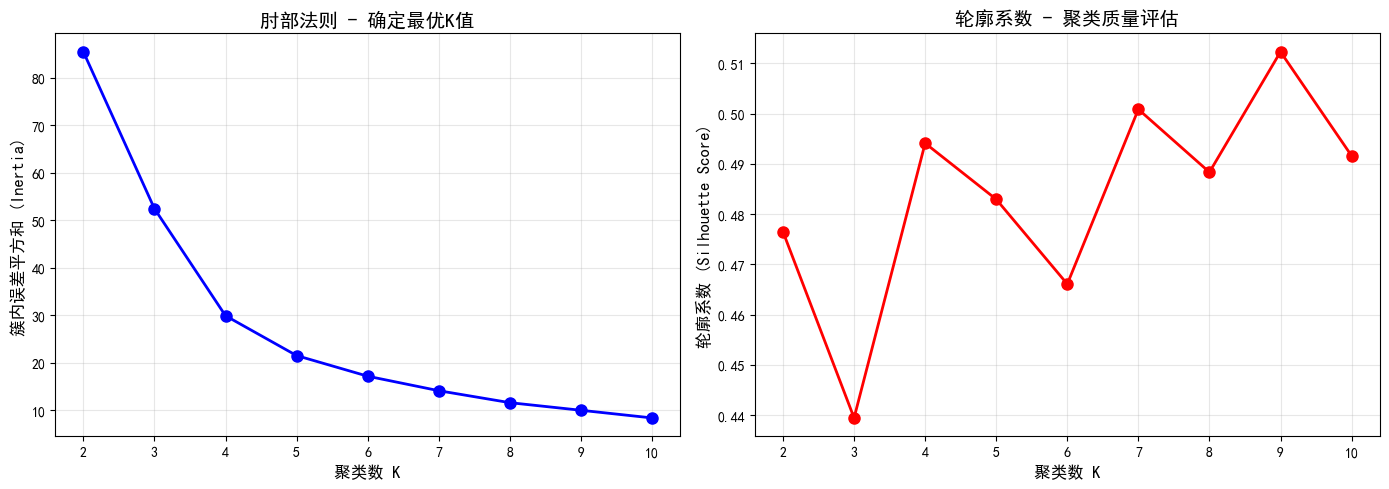


📊 推荐的最优聚类数: K = 9
   对应轮廓系数: 0.512


In [20]:
# 解决中文显示问题
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 准备聚类特征
features = ['salary_mid', 'education_level', 'experience_years', 'city_tier']
X = df_clean[features].values

# 标准化特征（重要！）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 测试不同的K值
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 肘部法则图
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('聚类数 K', fontsize=12)
ax1.set_ylabel('簇内误差平方和 (Inertia)', fontsize=12)
ax1.set_title('肘部法则 - 确定最优K值', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 轮廓系数图
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('聚类数 K', fontsize=12)
ax2.set_ylabel('轮廓系数 (Silhouette Score)', fontsize=12)
ax2.set_title('轮廓系数 - 聚类质量评估', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 推荐最优K值
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n📊 推荐的最优聚类数: K = {best_k}")
print(f"   对应轮廓系数: {max(silhouette_scores):.3f}")

### 4.2.4 模型训练与聚类中心分析

使用最优K值训练最终的聚类模型。


In [21]:
# 使用最优K值训练模型
optimal_k = 4  # 可根据上面的结果调整

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

# 聚类中心（反标准化）
cluster_centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
centers_df = pd.DataFrame(
    cluster_centers,
    columns=features,
    index=[f'类别 {i}' for i in range(optimal_k)]
)

print(f"✓ K-Means 聚类完成！")
print(f"\n聚类中心特征:")
print(centers_df.round(2))

# 各类别职位数量
print(f"\n各类别职位分布:")
print(df_clean['cluster'].value_counts().sort_index())


✓ K-Means 聚类完成！

聚类中心特征:
      salary_mid  education_level  experience_years  city_tier
类别 0       28.66             3.12              3.75        3.0
类别 1       31.81             3.00              0.22        3.0
类别 2       31.88             0.00              1.75        3.0
类别 3       82.50             4.00              1.50        3.0

各类别职位分布:
cluster
0    16
1    18
2     4
3     2
Name: count, dtype: int64


### 4.2.5 聚类结果解读

分析每个聚类的特征，为其命名并提供求职建议。


In [22]:
# 计算每个聚类的统计特征
cluster_stats = df_clean.groupby('cluster').agg({
    'salary_mid': ['mean', 'median', 'std'],
    'education_level': 'mean',
    'experience_years': 'mean',
    'city_tier': 'mean',
    'name': 'count'
}).round(2)

cluster_stats.columns = ['平均薪资', '中位薪资', '薪资标准差', '平均学历', '平均经验', '平均城市等级', '职位数量']

print("=" * 80)
print("聚类统计特征")
print("=" * 80)
print(cluster_stats)

# 为每个聚类命名（基于特征）
cluster_names = {}
for i in range(optimal_k):
    avg_salary = cluster_stats.loc[i, '平均薪资']
    avg_edu = cluster_stats.loc[i, '平均学历']
    avg_exp = cluster_stats.loc[i, '平均经验']

    if avg_salary > 25:
        if avg_edu >= 3.5:
            cluster_names[i] = "高薪技术岗"
        else:
            cluster_names[i] = "高薪管理岗"
    elif avg_salary > 15:
        if avg_exp < 2:
            cluster_names[i] = "中薪初级岗"
        else:
            cluster_names[i] = "中薪成熟岗"
    else:
        cluster_names[i] = "入门级岗位"

print(f"\n" + "=" * 80)
print("聚类命名与建议")
print("=" * 80)
for cluster_id, name in cluster_names.items():
    stats = cluster_stats.loc[cluster_id]
    print(f"\n【类别 {cluster_id}: {name}】")
    print(f"  💰 薪资范围: {stats['中位薪资']:.0f}k")
    print(f"  🎓 学历要求: {stats['平均学历']:.1f} (0=不限, 3=本科, 4=硕士)")
    print(f"  📅 经验要求: {stats['平均经验']:.1f} 年")
    print(f"  📍 城市等级: {stats['平均城市等级']:.1f} (3=一线, 2=新一线)")
    print(f"  📊 职位数量: {int(stats['职位数量'])} 个")


聚类统计特征
          平均薪资   中位薪资  薪资标准差  平均学历  平均经验  平均城市等级  职位数量
cluster                                               
0        28.66  26.00   9.14  3.12  3.75     3.0    16
1        31.81  30.00  11.96  3.00  0.22     3.0    18
2        31.88  34.75   9.58  0.00  1.75     3.0     4
3        82.50  82.50  10.61  4.00  1.50     3.0     2

聚类命名与建议

【类别 0: 高薪管理岗】
  💰 薪资范围: 26k
  🎓 学历要求: 3.1 (0=不限, 3=本科, 4=硕士)
  📅 经验要求: 3.8 年
  📍 城市等级: 3.0 (3=一线, 2=新一线)
  📊 职位数量: 16 个

【类别 1: 高薪管理岗】
  💰 薪资范围: 30k
  🎓 学历要求: 3.0 (0=不限, 3=本科, 4=硕士)
  📅 经验要求: 0.2 年
  📍 城市等级: 3.0 (3=一线, 2=新一线)
  📊 职位数量: 18 个

【类别 2: 高薪管理岗】
  💰 薪资范围: 35k
  🎓 学历要求: 0.0 (0=不限, 3=本科, 4=硕士)
  📅 经验要求: 1.8 年
  📍 城市等级: 3.0 (3=一线, 2=新一线)
  📊 职位数量: 4 个

【类别 3: 高薪技术岗】
  💰 薪资范围: 82k
  🎓 学历要求: 4.0 (0=不限, 3=本科, 4=硕士)
  📅 经验要求: 1.5 年
  📍 城市等级: 3.0 (3=一线, 2=新一线)
  📊 职位数量: 2 个


### 4.2.6 聚类应用示例

展示如何在推荐系统中使用聚类结果。


In [23]:
# 示例：基于聚类的职位推荐
def recommend_by_cluster(user_target_salary, user_education, user_experience, top_n=5):
    """
    根据用户画像推荐同类职位
    """
    # 构造用户特征向量
    user_features = np.array([[user_target_salary, user_education, user_experience, 2]])
    user_features_scaled = scaler.transform(user_features)

    # 预测用户所属聚类
    user_cluster = kmeans_final.predict(user_features_scaled)[0]

    # 推荐同类职位
    cluster_jobs = df_clean[df_clean['cluster'] == user_cluster]
    recommendations = cluster_jobs.nlargest(top_n, 'salary_mid')[['name', 'company', 'salary', 'place']]

    print(f"用户画像: 目标薪资{user_target_salary}k, 学历等级{user_education}, 经验{user_experience}年")
    print(f"匹配聚类: 类别 {user_cluster} - {cluster_names.get(user_cluster, '未命名')}")
    print(f"\n推荐职位 (Top {top_n}):")
    return recommendations

# 测试推荐
recommend_by_cluster(user_target_salary=20, user_education=3, user_experience=3)


用户画像: 目标薪资20k, 学历等级3, 经验3年
匹配聚类: 类别 0 - 高薪管理岗

推荐职位 (Top 5):


,name,company,salary,place
2,服务端工程师(go/python),NaN,30-60k·14薪,北京
30,Python后端开发工程师,某知名互联网公司,30-60k·16薪,北京-海淀区
27,【头部量化基金】测试开发工程师，（需精通 Python 开发）,某北京基金/证券/期货公司,30-50k·16薪,北京
20,Python开发工程师,某科技金融公司,25-50k,北京
38,Python开发,NaN,25-40k·15薪,北京-朝阳区


## 4.3 聚类与推荐的协同应用

聚类结果可以增强推荐系统的效果：
- 基于聚类的冷启动推荐
- 同类职位推荐
- 用户画像与职位类别匹配


# 第五章 数据可视化：市场洞察

## 章节概述

本章通过多维度可视化分析，展示职位市场的特征和趋势。

---


In [24]:
import matplotlib.font_manager as fm
# 🛠️ 自动修复：检测并配置可用中文字体

# 清理 matplotlib 缓存以防字体映射错误
cache_dir = os.path.expanduser("~/.cache/matplotlib")
if os.path.exists(cache_dir):
    try:
        import shutil
        shutil.rmtree(cache_dir)
    except Exception:
        pass

# 候选字体列表 (针对 Linux 环境优化)
font_candidates = ["Noto Sans CJK SC", "WenQuanYi Zen Hei", "SimHei", "Arial Unicode MS"]
found_font = None
# Force font cache rebuild by clearing and reloading
try:
    import shutil
    shutil.rmtree(cache_dir)
except Exception:
    pass
fm.fontManager.__init__() # 强制刷新字体列表

for font in font_candidates:
    if any(font in f.name for f in fm.fontManager.ttflist):
        found_font = font
        break

if found_font:
    plt.rcParams["font.sans-serif"] = [found_font] + plt.rcParams["font.sans-serif"]
    print(f"✅ 已成功匹配中文字体: {found_font}")
else:
    print("⚠️ 未找到合适的中文字体，图表可能无法正常显示中文。")

plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12


Matplotlib is building the font cache; this may take a moment.


✅ 已成功匹配中文字体: SimHei


### 5.1 教育程度分布分析 (Education Requirement)
反映了职场准入门槛。

In [25]:
refresh_db_connection()

print("📊 教育程度数据统计：")
print("=" * 60)

edu_list = ['博士', '硕士', '本科', '大专', '不限']
total = models.JobData.objects.count()

for edu in edu_list:
    count = models.JobData.objects.filter(education__icontains=edu).count()
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {edu:<6}: {count:>5} 条 ({percentage:>5.1f}%)")

print(f"\n  总计: {total} 条职位数据")

⚠️ 数据库刷新失败: (2003, "Can't connect to MySQL server on '154.37.219.217' (timed out)")
📊 教育程度数据统计：
  博士    :    21 条 (  0.2%)
  硕士    :   391 条 (  3.5%)
  本科    :  8603 条 ( 77.8%)
  大专    :  1479 条 ( 13.4%)
  不限    :   538 条 (  4.9%)

  总计: 11053 条职位数据


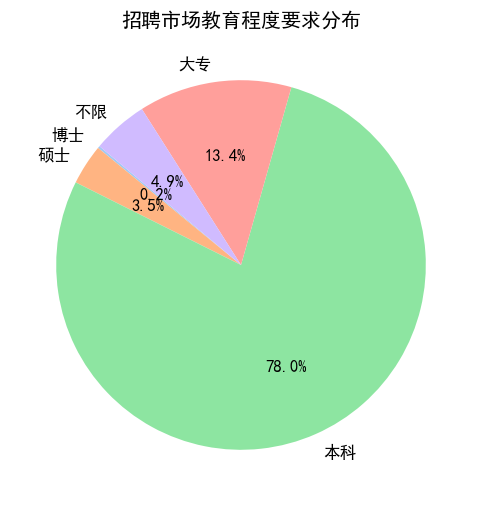

In [26]:
edu_list = ['博士', '硕士', '本科', '大专', '不限']
edu_values = [models.JobData.objects.filter(education__icontains=e).count() for e in edu_list]

plt.figure(figsize=(8, 6))
plt.pie(edu_values, labels=edu_list, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('招聘市场教育程度要求分布')
plt.show()

### 5.2 薪资水平分布分析 (Salary Ranges)
直观展示各梯度岗位的薪资分布情况。

In [27]:
refresh_db_connection()

print("💰 薪资水平数据统计：")
print("=" * 60)

import re

salary_ranges = {
    '5K及以下': 0,
    '5-10K': 0,
    '10K-15K': 0,
    '15K-20K': 0,
    '20K-30K': 0,
    '30-50K': 0,
    '50K以上': 0
}

all_jobs = models.JobData.objects.all()
for job in all_jobs:
    if job.salary:
        match = re.findall(r'-(\d+)k', job.salary.lower())
        if match:
            max_sal = int(match[0])
            if max_sal <= 5:
                salary_ranges['5K及以下'] += 1
            elif max_sal <= 10:
                salary_ranges['5-10K'] += 1
            elif max_sal <= 15:
                salary_ranges['10K-15K'] += 1
            elif max_sal <= 20:
                salary_ranges['15K-20K'] += 1
            elif max_sal <= 30:
                salary_ranges['20K-30K'] += 1
            elif max_sal <= 50:
                salary_ranges['30-50K'] += 1
            else:
                salary_ranges['50K以上'] += 1

total = sum(salary_ranges.values())
for range_name, count in salary_ranges.items():
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {range_name:<10}: {count:>5} 条 ({percentage:>5.1f}%)")

print(f"\n  总计: {total} 条有效薪资数据")

✅ 数据库连接已刷新，可安全进行查询。
💰 薪资水平数据统计：
  5K及以下     :   116 条 (  1.1%)
  5-10K     :   946 条 (  8.7%)
  10K-15K   :  2177 条 ( 20.1%)
  15K-20K   :  1952 条 ( 18.0%)
  20K-30K   :  3217 条 ( 29.7%)
  30-50K    :  1811 条 ( 16.7%)
  50K以上     :   602 条 (  5.6%)

  总计: 10821 条有效薪资数据


### 5.3 地区（城市）分布分析 (Region Distribution)
分析各城市的人才需求集中度。

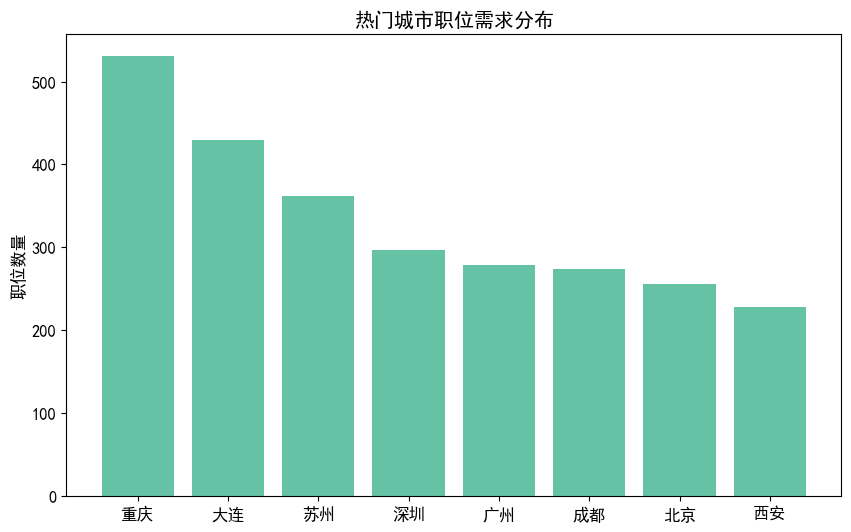

In [28]:
from django.db.models import Count
city_counts = models.JobData.objects.values("place").annotate(count=Count("job_id")).order_by("-count")[:10]
cities = [c["place"][:2] for c in city_counts]  # 取简写如 "北京"
counts = [c["count"] for c in city_counts]

plt.figure(figsize=(10, 6))
plt.bar(cities, counts, color="#66c2a5")
plt.title("热门城市职位需求分布")
plt.ylabel("职位数量")
plt.show()

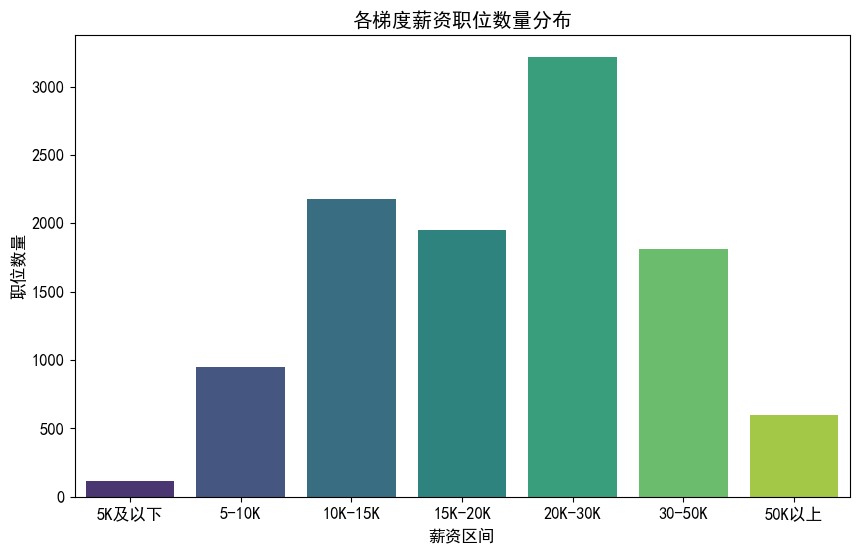

In [29]:
# 薪资梯度分类统计逻辑示例
ranges = ['5K及以下', '5-10K', '10K-15K', '15K-20K', '20K-30K', '30-50K', '50K以上']
values = [0, 0, 0, 0, 0, 0, 0] # 实际运行时会从数据库提取解析

jobs = models.JobData.objects.all()
for job in jobs:
    match = re.findall(r'-(\d+)k', job.salary)
    if match:
        s = float(match[0])
        if s <= 5: values[0] += 1
        elif s <= 10: values[1] += 1
        elif s <= 15: values[2] += 1
        elif s <= 20: values[3] += 1
        elif s <= 30: values[4] += 1
        elif s <= 50: values[5] += 1
        else: values[6] += 1

plt.figure(figsize=(10, 6))
sns.barplot(x=ranges, y=values, hue=ranges, palette='viridis', legend=False)
plt.title('各梯度薪资职位数量分布')
plt.ylabel('职位数量')
plt.xlabel('薪资区间')
plt.show()

### 5.4 核心技术关键词统计 (Top Keywords)
代表了当前技术选型的主流特征。

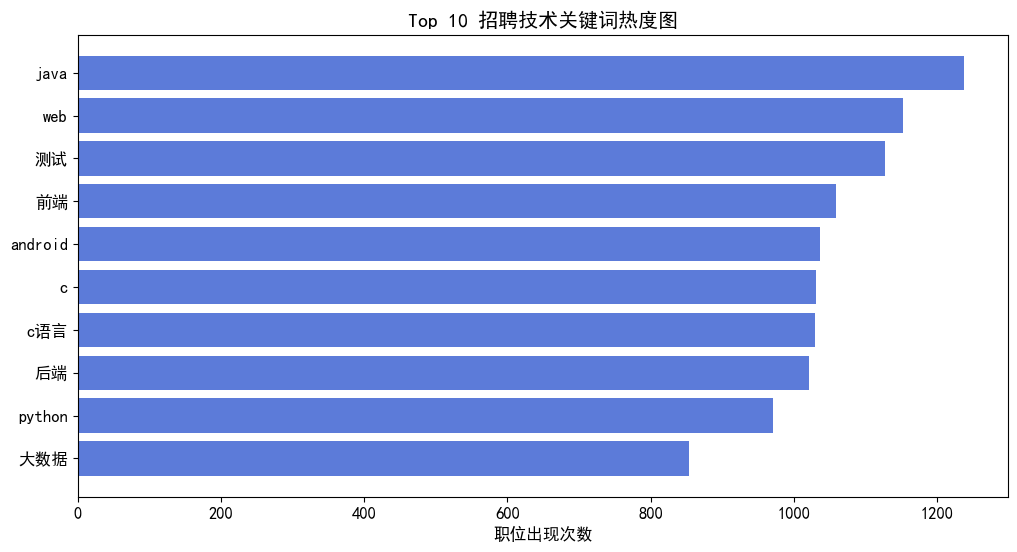

In [30]:
keywords = [x['key_word'].strip() for x in models.JobData.objects.values('key_word') if x['key_word']]
key_counts = Counter(keywords).most_common(10)
x_keys = [k[0] for k in key_counts]
y_counts = [k[1] for k in key_counts]

plt.figure(figsize=(12, 6))
plt.barh(x_keys, y_counts, color='#5c7bd9')
plt.gca().invert_yaxis()
plt.title('Top 10 招聘技术关键词热度图')
plt.xlabel('职位出现次数')
plt.show()

## 5.5 聚类结果可视化

展示K-Means聚类的多维度可视化结果。


数据库连接已刷新
数据库职位总数: 11053
有效薪资数据行数: 10824
最终用于绘图的数据行数: 10824


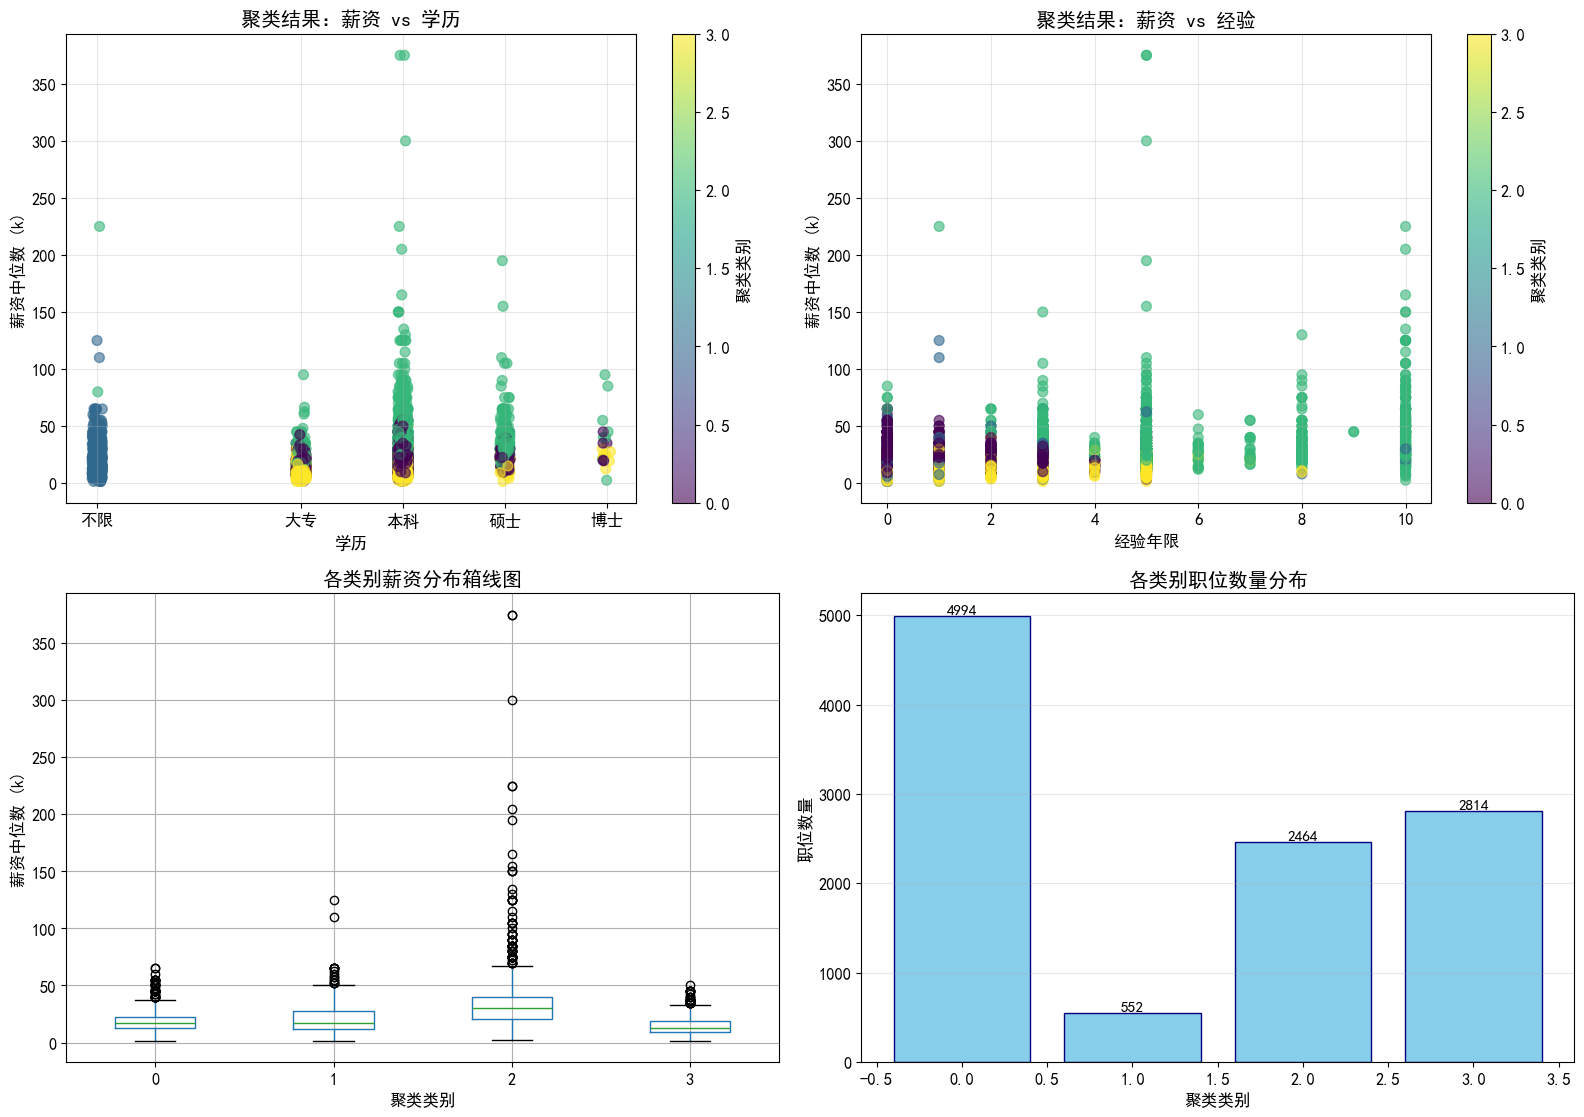

In [31]:
import os
import django
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "JobRecommend.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from job import models
from django.db import close_old_connections, connection


def refresh_db_connection():
    try:
        close_old_connections()
        connection.ensure_connection()
        print("数据库连接已刷新")
    except Exception as e:
        print("数据库刷新失败:", e)


def load_jobs_from_db():
    refresh_db_connection()
    qs = models.JobData.objects.all()
    df = pd.DataFrame(
        list(
            qs.values(
                "name",
                "company",
                "place",
                "salary",
                "education",
                "experience",
            )
        )
    )
    print("数据库职位总数:", len(df))
    return df


def extract_salary_mid(salary_str):
    if pd.isna(salary_str):
        return np.nan
    s = str(salary_str).lower()
    nums = re.findall(r"(\d+)", s)
    if len(nums) >= 2:
        return (int(nums[0]) + int(nums[1])) / 2
    if len(nums) == 1:
        return float(nums[0])
    return np.nan


education_map = {
    "博士": 5,
    "硕士": 4,
    "本科": 3,
    "统招本科": 3,
    "大专": 2,
    "高中": 1,
    "不限": 0,
    "学历不限": 0,
}


def map_education(edu_str):
    if pd.isna(edu_str):
        return 0
    text = str(edu_str)
    for key, val in education_map.items():
        if key in text:
            return val
    return 0


def extract_experience(exp_str):
    if pd.isna(exp_str):
        return 0
    text = str(exp_str)
    m = re.search(r"(\d+)", text)
    if m:
        return int(m.group(1))
    if "不限" in text or "应届" in text:
        return 0
    return 1


tier1_cities = ["北京", "上海", "广州", "深圳"]
tier2_cities = ["杭州", "成都", "武汉", "南京", "苏州", "西安"]


def city_tier(place_str):
    if pd.isna(place_str):
        return 0
    text = str(place_str)
    for c in tier1_cities:
        if c in text:
            return 3
    for c in tier2_cities:
        if c in text:
            return 2
    return 1


def prepare_features(df):
    df = df.copy()
    df["salary_mid"] = df["salary"].apply(extract_salary_mid)
    df["education_level"] = df["education"].apply(map_education)
    df["experience_years"] = df["experience"].apply(extract_experience)
    df["city_tier"] = df["place"].apply(city_tier)
    df_clean = df.dropna(subset=["salary_mid"]).copy()
    print("有效薪资数据行数:", len(df_clean))
    return df_clean


def cluster_jobs(df_clean, k=4):
    features = ["salary_mid", "education_level", "experience_years", "city_tier"]
    X = df_clean[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_clustered = df_clean.copy()
    df_clustered["cluster"] = kmeans.fit_predict(X_scaled)
    return df_clustered


def plot_cluster_views(df_clean):
    education_labels = {
        0: "不限",
        1: "高中",
        2: "大专",
        3: "本科",
        4: "硕士",
        5: "博士",
    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("薪资数据多维度分析", fontsize=20)

    x1 = df_clean["education_level"].values.astype(float)
    y1 = df_clean["salary_mid"].values.astype(float)
    jitter = (np.random.rand(len(x1)) - 0.5) * 0.1

    scatter1 = axes[0, 0].scatter(
        x1 + jitter,
        y1,
        c=df_clean["cluster"],
        cmap="viridis",
        alpha=0.6,
        s=50,
    )
    levels = sorted(df_clean["education_level"].unique())
    axes[0, 0].set_xticks(levels)
    axes[0, 0].set_xticklabels([education_labels.get(int(l), str(l)) for l in levels])
    axes[0, 0].set_xlabel("学历")
    axes[0, 0].set_ylabel("薪资中位数 (k)")
    axes[0, 0].set_title("聚类结果：薪资 vs 学历")
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label="聚类类别")

    scatter2 = axes[0, 1].scatter(
        df_clean["experience_years"],
        df_clean["salary_mid"],
        c=df_clean["cluster"],
        cmap="viridis",
        alpha=0.6,
        s=50,
    )
    axes[0, 1].set_xlabel("经验年限")
    axes[0, 1].set_ylabel("薪资中位数 (k)")
    axes[0, 1].set_title("聚类结果：薪资 vs 经验")
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label="聚类类别")

    df_clean.boxplot(column="salary_mid", by="cluster", ax=axes[1, 0])
    axes[1, 0].set_xlabel("聚类类别")
    axes[1, 0].set_ylabel("薪资中位数 (k)")
    axes[1, 0].set_title("各类别薪资分布箱线图")
    axes[1, 0].get_figure().suptitle("")

    cluster_counts = df_clean["cluster"].value_counts().sort_index()
    axes[1, 1].bar(
        cluster_counts.index,
        cluster_counts.values,
        color="skyblue",
        edgecolor="navy",
    )
    axes[1, 1].set_xlabel("聚类类别")
    axes[1, 1].set_ylabel("职位数量")
    axes[1, 1].set_title("各类别职位数量分布")
    axes[1, 1].grid(True, alpha=0.3, axis="y")
    for i, v in enumerate(cluster_counts.values):
        axes[1, 1].text(i, v, str(v), ha="center", va="bottom", fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def main():
    df_raw = load_jobs_from_db()
    df_features = prepare_features(df_raw)
    df_clustered = cluster_jobs(df_features, k=4)
    print("最终用于绘图的数据行数:", len(df_clustered))
    plot_cluster_views(df_clustered)


main()